In [1]:
#scientific libraries and plotting
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sn

#torch specific
import torch

#other libraries
import sys
from pathlib import Path
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import atlas_mpl_style as ampl

In [2]:
# import custom functions from src folder
module_path = str(Path.cwd().parents[0] / "src")

if module_path not in sys.path:
    sys.path.append(module_path)

from machine_learning import *
from resnet import *
from imcal import *

from resnet import ResNet18

# Predict using resnet

This notebook uses a saved resnet model to predict on test data and generate a confusion matrix. It also saves the wrong predictions for further analysis.

In [24]:
#variables controlled by the user. Change these to fit your specific needs.
RES = 50 #resolution

LABELS = ["PP13-Sphaleron-THR9-FRZ15-NB0-NSUBPALL", "BH_n2_M10", "BH_n4_M8", "BH_n4_M10", "BH_n4_M12", "BH_n6_M10"]
TEST_LABELS = [f"{label}_test" for label in LABELS]
PLOT_LABELS = ["SPH_9", "BH_n4_M8", "BH_n2_M10", "BH_n4_M10", "BH_n6_M10", "BH_n4_M12"]
PLOT_ORDER = [0, 2, 1, 3, 5, 4]
CLASSES = len(LABELS) #The number of output nodes in the net, equal to the number of classes
FOLDERS = ["sph", "BH", "BH", "BH", "BH", "BH"]
TEST_N_EVENTS = 15000
CUT=True

#Set data paths
if CUT:
    N_EVENTS = 15000
    TEST_FILENAMES = [f"{label}_res{RES}_STmin7_Nmin5_{N_EVENTS}_events.h5" for label in TEST_LABELS]
else:
    N_EVENTS = 3000
    TEST_FILENAMES = [f"{label}_res{RES}_{N_EVENTS}_events.h5" for label in TEST_LABELS]
TEST_DATAPATHS = [f"/disk/atlas3/data_MC/2dhistograms/{FOLDERS[i]}/{RES}/{TEST_FILENAMES[i]}" for i in range(CLASSES)]

MODEL_NAME = "resnet18_1703078471_SPH_9_BH_n2_M10_BH_n4_M8_BH_n4_M10_BH_n4_M12_BH_n6_M10_CUT"
LOAD_FOLDER = "../results/models/experiment_resnet18_1703074946_SPH_9_BH_n2_M10_BH_n4_M8_BH_n4_M10_BH_n4_M12_BH_n6_M10_CUT"

LOAD_PATH = f"{LOAD_FOLDER}/{MODEL_NAME}.pt"

if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
    torch.cuda.empty_cache()
    print("Running on the GPU")
else:
    DEVICE = torch.device("cpu")
    print("Running on the CPU")
DEVICE = torch.device("cpu")
ampl.use_atlas_style() 

Running on the GPU


In [25]:
#import model
model = ResNet18(img_channels=3, num_classes=len(TEST_LABELS))
model.load_state_dict(torch.load(LOAD_PATH))
model.eval()
model.to(DEVICE)
print("Loading model")

Loading model


In [26]:
#Load data
testpaths = [Path(path) for path in TEST_DATAPATHS]
test_data = load_datasets(testpaths, DEVICE, TEST_N_EVENTS, filters=[None], transforms=None)
#test_data = Hdf5Dataset(testpaths, TEST_LABELS, DEVICE, 
                        #shuffle=False, filters=[None], transform=None, event_limit=TEST_N_EVENTS)
#eventids = test_data.getids().flatten()
#if len(eventids) != len(test_data):
#    print("Error in lengths of arrays")


Loads data with transforms None and filters [None]


Loaded data with 15000 entries of shape (15000, 50, 50, 3).
Check max value: 25613.0859375.
Check max value: 25613.0859375.
Loaded data with 15000 entries of shape (15000, 50, 50, 3).
Check max value: 19851.11328125.
Check max value: 19851.11328125.
Loaded data with 15000 entries of shape (15000, 50, 50, 3).
Check max value: 23127.8984375.
Check max value: 23127.8984375.
Loaded data with 15000 entries of shape (15000, 50, 50, 3).
Check max value: 35996.286259531975.
Check max value: 35996.286259531975.
Data has shape torch.Size([50, 50, 3])
There are 4 classes.


In [27]:
truth, preds, confidences = predict(model, test_data, CLASSES, 100, RES, DEVICE, return_conf=True)

100%|██████████| 600/600 [00:21<00:00, 28.28it/s]


In [28]:
df = pd.DataFrame(dict(zip(["Truth", "Prediction"], [truth, preds])))
#df["EventID"] = eventids
accuracy = accuracy_score(truth, preds, normalize=True)
df['Confidence'] = torch.max(confidences, dim=-1)[0]

In [29]:
df

,Truth,Prediction,Confidence
0,0.0,0.0,0.941526
1,0.0,0.0,0.995739
2,0.0,0.0,0.993370
3,0.0,0.0,0.433060
4,0.0,0.0,0.615448
...,...,...,...
59995,3.0,3.0,0.982615
59996,3.0,3.0,0.993818
59997,3.0,3.0,0.659645
59998,3.0,3.0,0.973201


[92.28  4.21  3.18  0.33 10.39 70.57 18.19  0.85  4.51  7.97 80.68  6.83
  0.72  0.67  9.67 88.93]
Accuracy: 0.83115


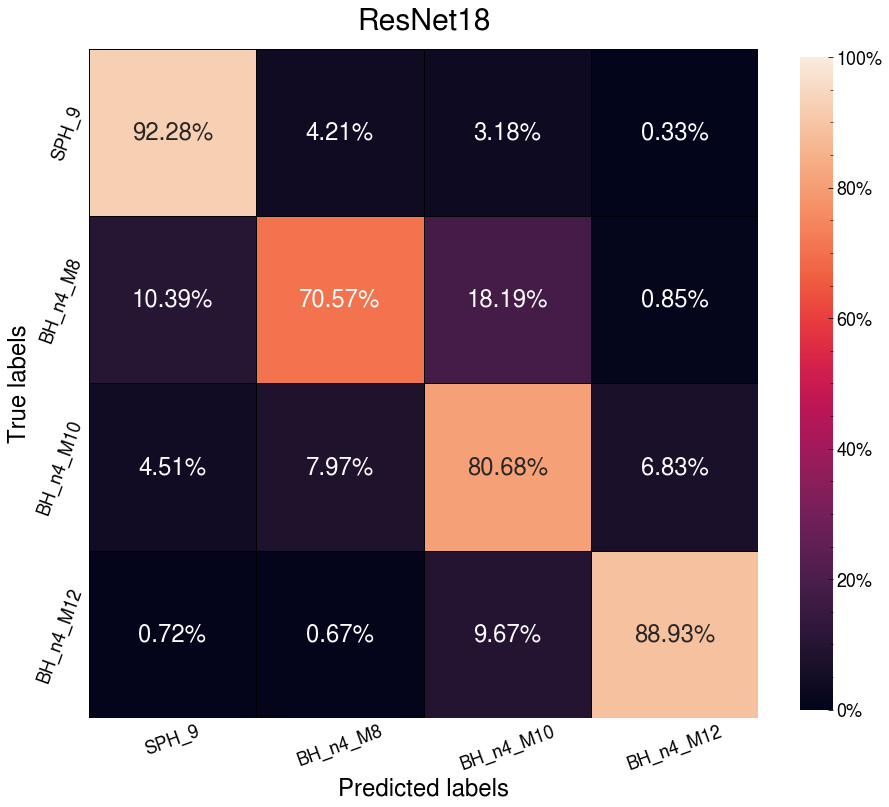

In [30]:
def plot_conf_matrix(confusion, accuracy, labels):
    """
    plot confusion matrix
    """
    fig, ax = plt.subplots(1,1, figsize=(15, 15))

    #Generate the confusion matrix
    cf_matrix = confusion_matrix(confusion["Truth"], confusion["Prediction"], normalize="true")
    cf_matrix = 100*np.round(cf_matrix, 4)
    cf_matrix = np.array([cf_matrix[i] for i in PLOT_ORDER])
    cf_matrix = np.array([np.array([row[j] for j in PLOT_ORDER]) for row in cf_matrix])
    print(cf_matrix.flatten())
    group_counts = ["{0:0.0f}".format(value*TEST_N_EVENTS) for value in cf_matrix.flatten()]
    group_percentages = ["{0:0.2%}".format(value/100) for value in cf_matrix.flatten()]
    annot = [f"{item}" for item in group_percentages]
    annot = np.asarray(annot).reshape(len(labels),len(labels))
    sn.heatmap(
            cf_matrix, 
            ax=ax, 
            annot=annot, 
            cmap='rocket', 
            linewidths=1.0, 
            linecolor='black',
            cbar = True, 
            square=True, 
            fmt='', 
            cbar_kws={"format": "%.0f%%", "shrink": 0.8},
            vmin=0,
            vmax=100,
            annot_kws={"size": 24}
        )

    #ax.set_title('Confusion matrix\n\n', size=24)
    ax.set_xlabel('Predicted labels', size=24)
    ax.set_ylabel('True labels', size=24)

    ## Ticket labels - List must be in alphabetical order
    ax.xaxis.set_ticklabels(labels, size=18, rotation=20)
    ax.yaxis.set_ticklabels(labels, size=18, rotation=70)
    ax.tick_params(which="both", left=False, bottom=False, top=False, right=False)
    ax.set_title(f"ResNet18", size=30, pad=20)
    print(f"Accuracy: {accuracy}")

    ## Display the visualization of the Confusion Matrix.
    fig.savefig(f"../results/figures/ResNet18_{TEST_N_EVENTS}_events_CUT_conf_matrix.pdf", format="pdf", bbox_inches='tight')
    plt.show()
plot_conf_matrix(df, accuracy, PLOT_LABELS)

In [31]:
df_wrong = df[df["Prediction"] != df["Truth"]]

In [32]:
#Look at the confidences
for i in range(len(LABELS)):
    temp = df[df["Truth"]==i]
    temp_len = len(temp)
    print(f"Predictions on truth {temp_len} {LABELS[i]} events:")
    for j in range(len(LABELS)):
        temp_preds = temp[temp["Prediction"]==j]
        print(f"{len(temp_preds)} events predicted as {LABELS[j]}")
        print(f"Average confidence: {temp_preds['Confidence'].mean()}, Std: {temp_preds['Confidence'].std()}")
    print("----")

Predictions on truth 15000 PP13-Sphaleron-THR9-FRZ15-NB0-NSUBPALL events:
13842 events predicted as PP13-Sphaleron-THR9-FRZ15-NB0-NSUBPALL
Average confidence: 0.9103682041168213, Std: 0.12298386543989182
631 events predicted as BH_n4_M8
Average confidence: 0.641659677028656, Std: 0.15867120027542114
477 events predicted as BH_n4_M10
Average confidence: 0.6187712550163269, Std: 0.15986640751361847
50 events predicted as BH_n4_M12
Average confidence: 0.5370656847953796, Std: 0.15303711593151093
----
Predictions on truth 15000 BH_n4_M8 events:
1558 events predicted as PP13-Sphaleron-THR9-FRZ15-NB0-NSUBPALL
Average confidence: 0.7126830816268921, Std: 0.1715824455022812
10585 events predicted as BH_n4_M8
Average confidence: 0.8254319429397583, Std: 0.15473070740699768
2729 events predicted as BH_n4_M10
Average confidence: 0.7124450206756592, Std: 0.1647934764623642
128 events predicted as BH_n4_M12
Average confidence: 0.5856139063835144, Std: 0.16920818388462067
----
Predictions on truth 1

In [33]:
def save_wrong_predictions(truths, labels, eventids, savepath, filename):
    file = open(f"{savepath}/{filename}.csv", "w")
    file.write(f"Wrongly predicted events from datasets: {testpaths} by model {MODEL_NAME}")
    for i, truth in enumerate(truths):
        file.write(f"{labels[int(truth)]}, {eventids[i]}\n")
    file.close()
    print(f"Saved results to {savepath}/{filename}.csv")
    
filename = f"{MODEL_NAME}_{TEST_N_EVENTS}_events_wrongly_predicted"
#save_wrong_predictions(df_wrong["Truth"].tolist(), PLOT_LABELS, df_wrong["EventID"].tolist(), "../results/", filename)